In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
plt.rcParams.update({'font.size': 22})

from energy_centre import EnergyCentre

## Scenario 1 - Curtailed wind modelled 2020

In [3]:
timestep = '0.5H'
timestamp_from = '2020-01-01 00:00:00'
timestamp_to = '2020-12-31 23:30:00'
TwentyTwenty = EnergyCentre(timestep=timestep, timestamp_from=timestamp_from, timestamp_to=timestamp_to)
TwentyTwenty.get_data_scottish_borders()

TwentyTwenty.apply_constraint_discount(future=2020, discount=50, discount_level=1000)

TwentyTwenty.add_bus('heat')
TwentyTwenty.add_bus('elec')
TwentyTwenty.add_heat_demand()
TwentyTwenty.add_elec_demand()
TwentyTwenty.add_grid_connection()
TwentyTwenty.add_resistive_heater(extendable=True)
TwentyTwenty.add_heat_pump(extendable=True)
TwentyTwenty.add_short_term_store(extendable=True)
TwentyTwenty.add_long_term_store(extendable=True)

# run LOPF
TwentyTwenty.network.lopf(solver_name="gurobi",
                          #   pyomo=False,
                          #   keep_shadowprices=True,
                          )

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x193253_copy
  Lower bound: 86502.22303114376
  Upper bound: 86502.22303114376
  Number of objectives: 1
  Number of constraints: 386497
  Number of variables: 193253
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 193253
  Number of nonzeros: 720287
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminati

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

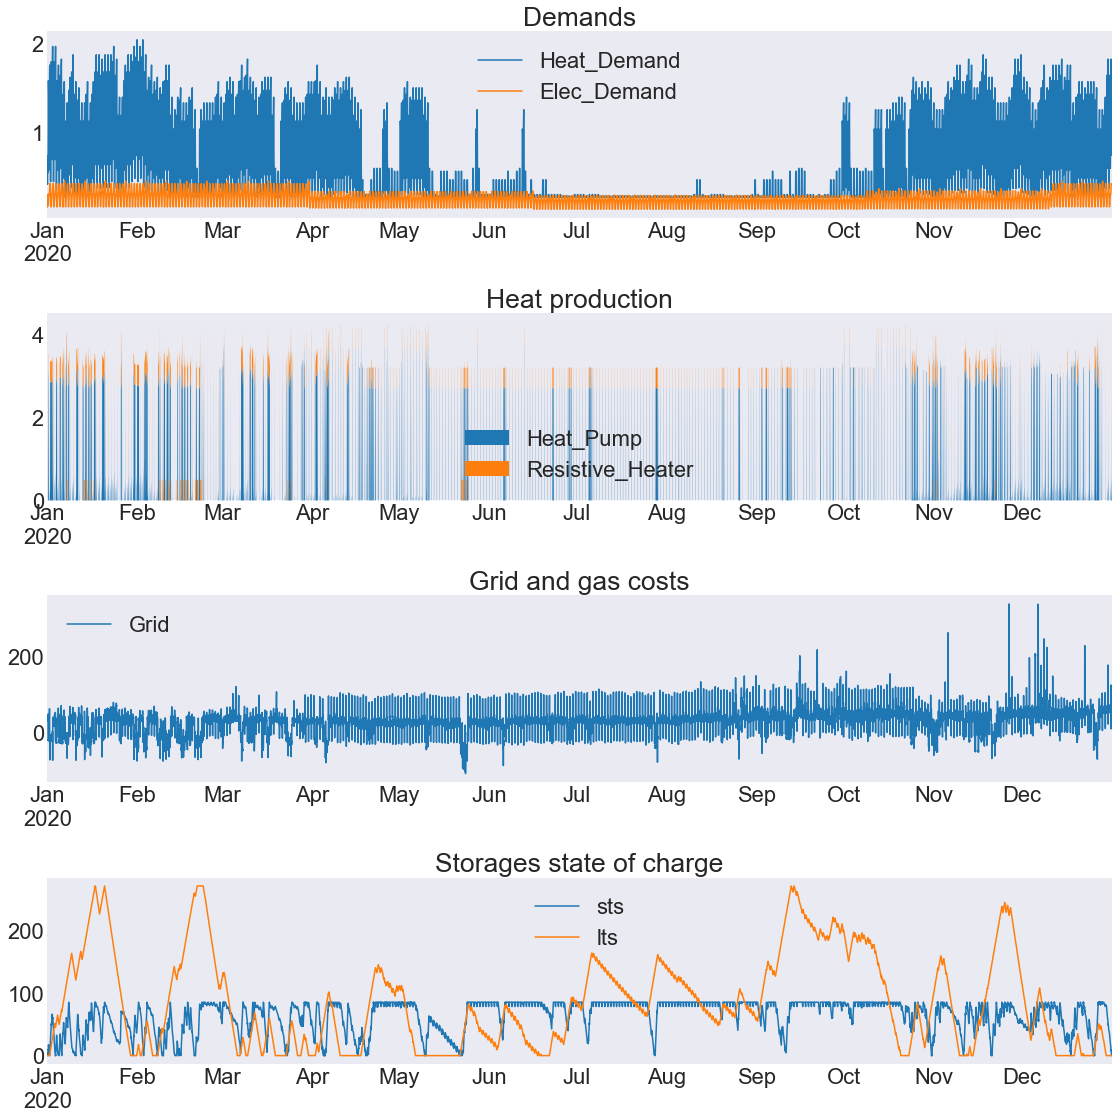

In [4]:
TwentyTwenty.network.generators_t.p['Heat_Pump'] = TwentyTwenty.network.links_t.p1.Heat_Pump * -1
TwentyTwenty.network.generators_t.p['Resistive_Heater'] = TwentyTwenty.network.links_t.p1.Resistive_Heater * -1
# ScotBord.network.generators_t.marginal_cost['Gas_Boiler'] = ScotBord.network.generators.marginal_cost.Gas_Boiler

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

TwentyTwenty.network.loads_t.p.rename_axis('').plot(ax=axs[0], title='Demands')
TwentyTwenty.network.generators_t.p.rename_axis('').drop(columns=['Grid']).plot.area(ax=axs[1], linewidth=0, title='Heat production')
TwentyTwenty.network.generators_t.marginal_cost.rename_axis('').plot(ax=axs[2], title='Grid and gas costs')
TwentyTwenty.network.stores_t.e.rename_axis('').plot(ax=axs[3], title='Storages state of charge')

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

In [5]:
TwentyTwenty.carbon_calculator(TwentyTwenty.network.generators_t.p.Grid, curtailed_wind=True)
TwentyTwenty.total_carbon_emissions = TwentyTwenty.carbon_emissions.sum().round(2)
TwentyTwenty.total_carbon_emissions

327985.26

In [6]:
TwentyTwenty.total_costs_obj = TwentyTwenty.network.objective + TwentyTwenty.network.objective_constant
TwentyTwenty.total_costs_obj

122727.22303114376

In [7]:
TwentyTwenty.capex = (TwentyTwenty.network.links.p_nom_opt.Resistive_Heater * TwentyTwenty.network.links.capital_cost.Resistive_Heater +
                       TwentyTwenty.network.links.p_nom_opt.Heat_Pump * TwentyTwenty.network.links.capital_cost.Heat_Pump +
                       TwentyTwenty.network.stores.e_nom_opt.sts * TwentyTwenty.network.stores.capital_cost.sts +
                       TwentyTwenty.network.stores.e_nom_opt.lts * TwentyTwenty.network.stores.capital_cost.lts) * 20
TwentyTwenty.capex

1010494.483608441

In [8]:
TwentyTwenty.opex = TwentyTwenty.total_costs_obj * 20 - TwentyTwenty.capex
TwentyTwenty.opex

1444049.977014434

In [9]:
TwentyTwenty.total_costs = TwentyTwenty.opex + TwentyTwenty.capex
TwentyTwenty.total_costs

2454544.460622875

## Scenario 2 - Curtailed wind modelled 2030

In [10]:
timestep = '0.5H'
timestamp_from = '2020-01-01 00:00:00'
timestamp_to = '2020-12-31 23:30:00'
TwentyThirty = EnergyCentre(timestep=timestep, timestamp_from=timestamp_from, timestamp_to=timestamp_to)
TwentyThirty.get_data_scottish_borders()

TwentyThirty.apply_constraint_discount(future=2030, discount=50, discount_level=1000)

TwentyThirty.add_bus('heat')
TwentyThirty.add_bus('elec')
TwentyThirty.add_heat_demand()
TwentyThirty.add_elec_demand()
TwentyThirty.add_grid_connection()
TwentyThirty.add_resistive_heater(extendable=True)
TwentyThirty.add_heat_pump(extendable=True)
TwentyThirty.add_short_term_store(extendable=True)
TwentyThirty.add_long_term_store(extendable=True)

# run LOPF
TwentyThirty.network.lopf(TwentyThirty.network.snapshots,
                          solver_name="gurobi",
                #         pyomo=False,
                #         keep_shadowprices=True,
                          )

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x193253_copy
  Lower bound: -117623.20803366507
  Upper bound: -117623.20803366507
  Number of objectives: 1
  Number of constraints: 386497
  Number of variables: 193253
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 193253
  Number of nonzeros: 720287
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termi

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

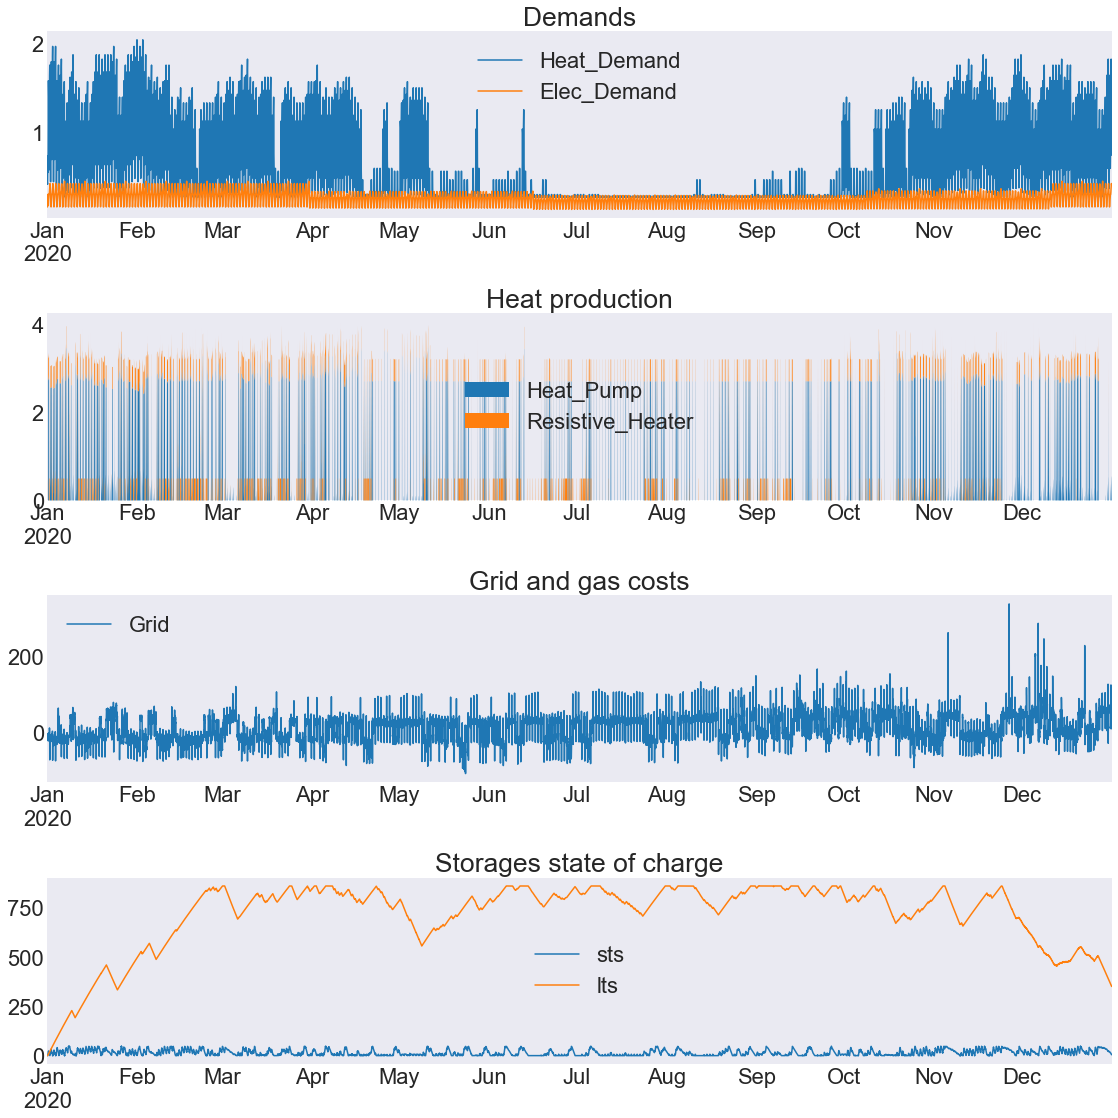

In [11]:
TwentyThirty.network.generators_t.p['Heat_Pump'] = TwentyThirty.network.links_t.p1.Heat_Pump * -1
TwentyThirty.network.generators_t.p['Resistive_Heater'] = TwentyThirty.network.links_t.p1.Resistive_Heater * -1
# ScotBord.network.generators_t.marginal_cost['Gas_Boiler'] = ScotBord.network.generators.marginal_cost.Gas_Boiler

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

TwentyThirty.network.loads_t.p.rename_axis('').plot(ax=axs[0], title='Demands')
TwentyThirty.network.generators_t.p.rename_axis('').drop(columns=['Grid']).plot.area(ax=axs[1], linewidth=0, title='Heat production')
TwentyThirty.network.generators_t.marginal_cost.rename_axis('').plot(ax=axs[2], title='Grid and gas costs')
TwentyThirty.network.stores_t.e.rename_axis('').plot(ax=axs[3], title='Storages state of charge')

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

In [12]:
TwentyThirty.carbon_calculator(TwentyThirty.network.generators_t.p.Grid, curtailed_wind=True)
TwentyThirty.total_carbon_emissions = TwentyThirty.carbon_emissions.sum().round(2)
TwentyThirty.total_carbon_emissions

173865.63

In [13]:
TwentyThirty.total_costs_obj = TwentyThirty.network.objective + TwentyThirty.network.objective_constant
TwentyThirty.total_costs_obj

-81398.20803366507

In [14]:
TwentyThirty.capex = (TwentyThirty.network.links.p_nom_opt.Resistive_Heater * TwentyThirty.network.links.capital_cost.Resistive_Heater +
                       TwentyThirty.network.links.p_nom_opt.Heat_Pump * TwentyThirty.network.links.capital_cost.Heat_Pump +
                       TwentyThirty.network.stores.e_nom_opt.sts * TwentyThirty.network.stores.capital_cost.sts +
                       TwentyThirty.network.stores.e_nom_opt.lts * TwentyThirty.network.stores.capital_cost.lts) * 20
TwentyThirty.capex

1131756.9311733095

In [15]:
TwentyThirty.opex = TwentyThirty.total_costs_obj * 20 - TwentyThirty.capex / 20
TwentyThirty.opex

-1684552.0072319668

In [16]:
TwentyThirty.total_costs = TwentyThirty.opex + TwentyThirty.capex
TwentyThirty.total_costs

-552795.0760586574

## Scenario 3 - Curtailed wind modelled 2040

In [17]:
timestep = '0.5H'
timestamp_from = '2020-01-01 00:00:00'
timestamp_to = '2020-12-31 23:30:00'
TwentyForty = EnergyCentre(timestep=timestep, timestamp_from=timestamp_from, timestamp_to=timestamp_to)
TwentyForty.get_data_scottish_borders()

TwentyForty.apply_constraint_discount(future=2040, discount=50, discount_level=1000)

TwentyForty.add_bus('heat')
TwentyForty.add_bus('elec')
TwentyForty.add_heat_demand()
TwentyForty.add_elec_demand()
TwentyForty.add_grid_connection()
TwentyForty.add_resistive_heater(extendable=True)
TwentyForty.add_heat_pump(extendable=True)
TwentyForty.add_short_term_store(extendable=True)
TwentyForty.add_long_term_store(extendable=True)

# run LOPF
TwentyForty.network.lopf(TwentyForty.network.snapshots,
                         solver_name="gurobi",
                #         pyomo=False,
                #         keep_shadowprices=True,
                         )

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x193253_copy
  Lower bound: -144516.1835490144
  Upper bound: -144516.1835490144
  Number of objectives: 1
  Number of constraints: 386497
  Number of variables: 193253
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 193253
  Number of nonzeros: 720287
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termina

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

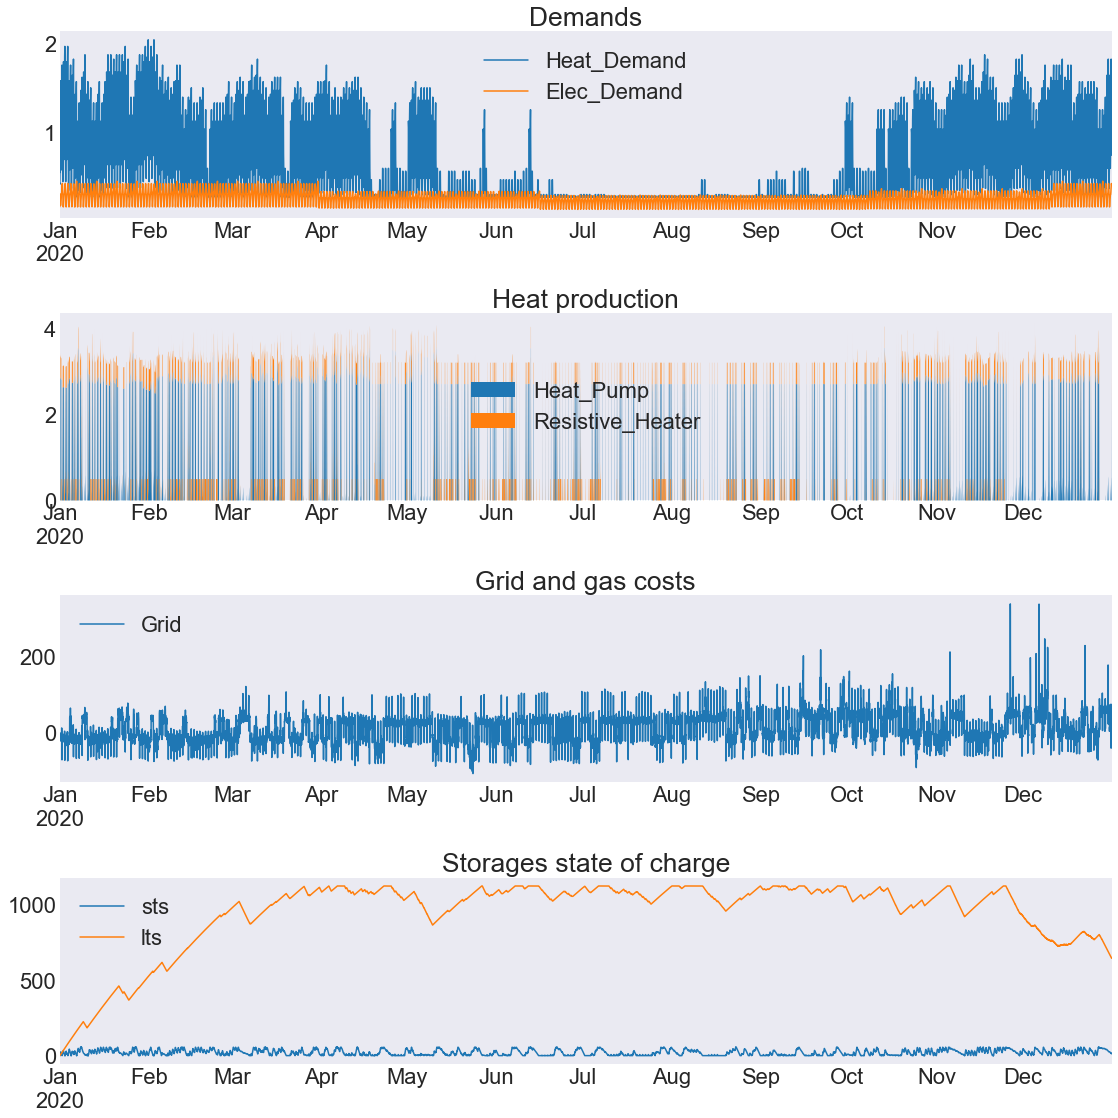

In [18]:
TwentyForty.network.generators_t.p['Heat_Pump'] = TwentyForty.network.links_t.p1.Heat_Pump * -1
TwentyForty.network.generators_t.p['Resistive_Heater'] = TwentyForty.network.links_t.p1.Resistive_Heater * -1
# ScotBord.network.generators_t.marginal_cost['Gas_Boiler'] = ScotBord.network.generators.marginal_cost.Gas_Boiler

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

TwentyForty.network.loads_t.p.rename_axis('').plot(ax=axs[0], title='Demands')
TwentyForty.network.generators_t.p.rename_axis('').drop(columns=['Grid']).plot.area(ax=axs[1], linewidth=0, title='Heat production')
TwentyForty.network.generators_t.marginal_cost.rename_axis('').plot(ax=axs[2], title='Grid and gas costs')
TwentyForty.network.stores_t.e.rename_axis('').plot(ax=axs[3], title='Storages state of charge')

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

<AxesSubplot:>

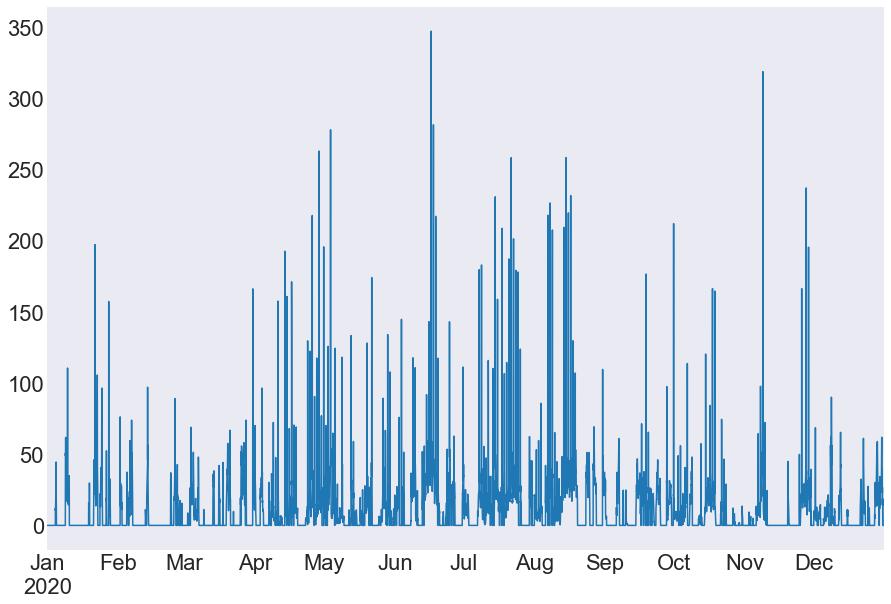

In [19]:
TwentyForty.carbon_calculator(TwentyForty.network.generators_t.p.Grid, curtailed_wind=True)
TwentyForty.total_carbon_emissions = TwentyForty.carbon_emissions.sum().round(2)
TwentyForty.total_carbon_emissions
TwentyForty.carbon_emissions.plot(figsize=(15,10))

In [20]:
TwentyForty.total_costs_obj = TwentyForty.network.objective + TwentyForty.network.objective_constant
TwentyForty.total_costs_obj

-108291.18354901439

In [21]:
TwentyForty.capex = (TwentyForty.network.links.p_nom_opt.Resistive_Heater * TwentyForty.network.links.capital_cost.Resistive_Heater +
                       TwentyForty.network.links.p_nom_opt.Heat_Pump * TwentyForty.network.links.capital_cost.Heat_Pump +
                       TwentyForty.network.stores.e_nom_opt.sts * TwentyForty.network.stores.capital_cost.sts +
                       TwentyForty.network.stores.e_nom_opt.lts * TwentyForty.network.stores.capital_cost.lts) * 20
TwentyForty.capex

1302130.1903021075

In [22]:
TwentyForty.opex = TwentyForty.total_costs_obj * 20 - TwentyForty.capex
TwentyForty.opex

-3467953.861282395

In [23]:
TwentyForty.total_costs = TwentyForty.opex + TwentyForty.capex
TwentyForty.total_costs

-2165823.6709802877

## Scenario 4 - Curtailed wind modelled 2050

In [24]:
timestep = '0.5H'
timestamp_from = '2020-01-01 00:00:00'
timestamp_to = '2020-12-31 23:30:00'
TwentyFifty = EnergyCentre(timestep=timestep, timestamp_from=timestamp_from, timestamp_to=timestamp_to)
TwentyFifty.get_data_scottish_borders()

TwentyFifty.apply_constraint_discount(future=2050, discount=50, discount_level=1000)

TwentyFifty.add_bus('heat')
TwentyFifty.add_bus('elec')
TwentyFifty.add_heat_demand()
TwentyFifty.add_elec_demand()
TwentyFifty.add_grid_connection()
TwentyFifty.add_resistive_heater(extendable=True)
TwentyFifty.add_heat_pump(extendable=True)
TwentyFifty.add_short_term_store(extendable=True)
TwentyFifty.add_long_term_store(extendable=True)

# run LOPF
TwentyFifty.network.lopf(TwentyFifty.network.snapshots,
                         solver_name="gurobi",
                #         pyomo=False,
                #         keep_shadowprices=True,
                         )

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x193253_copy
  Lower bound: -125334.0553496118
  Upper bound: -125334.0553496118
  Number of objectives: 1
  Number of constraints: 386497
  Number of variables: 193253
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 193253
  Number of nonzeros: 720287
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termina

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

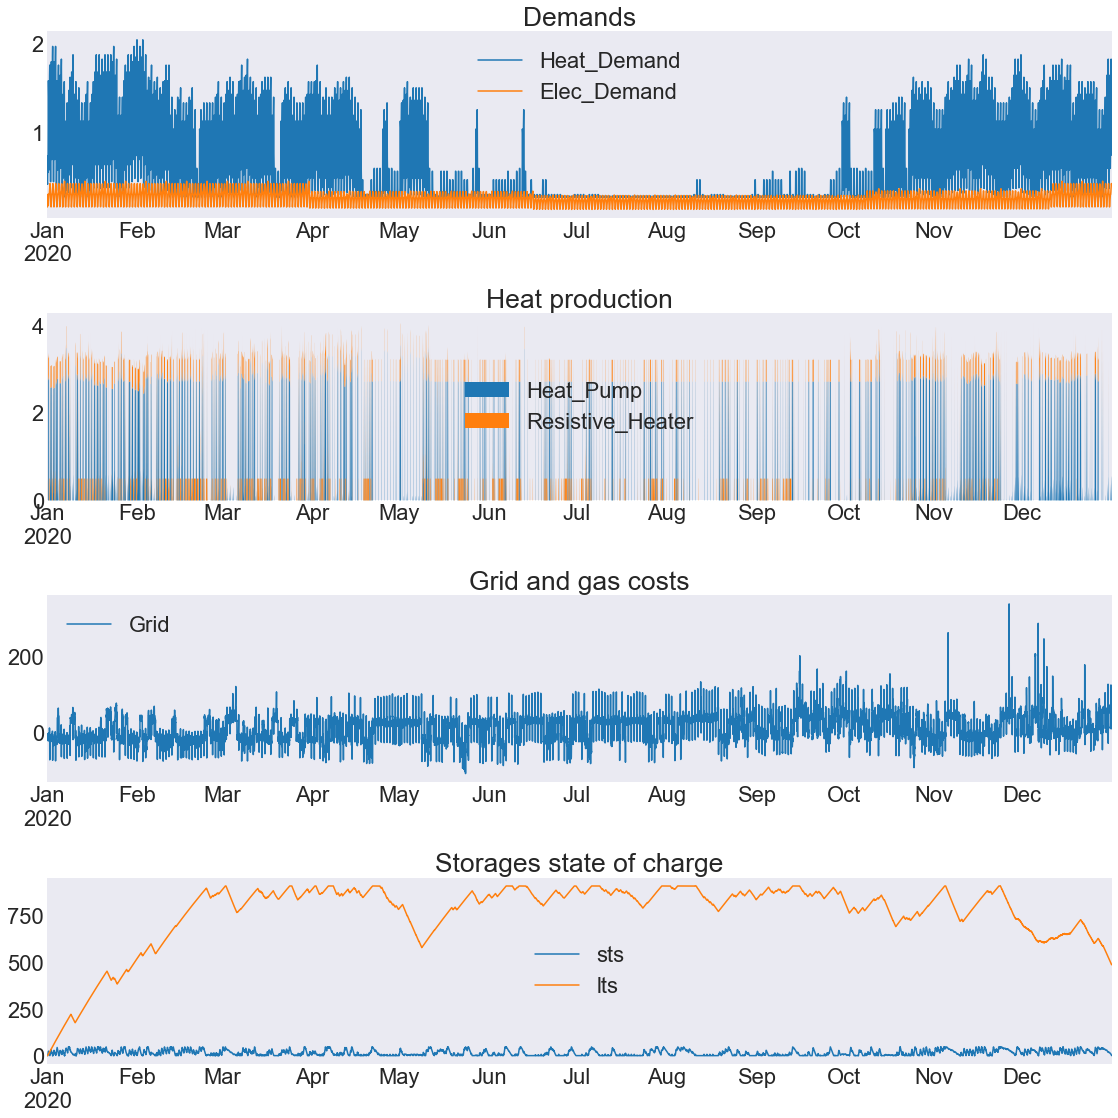

In [25]:
TwentyFifty.network.generators_t.p['Heat_Pump'] = TwentyFifty.network.links_t.p1.Heat_Pump * -1
TwentyFifty.network.generators_t.p['Resistive_Heater'] = TwentyFifty.network.links_t.p1.Resistive_Heater * -1
# ScotBord.network.generators_t.marginal_cost['Gas_Boiler'] = ScotBord.network.generators.marginal_cost.Gas_Boiler

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

TwentyFifty.network.loads_t.p.rename_axis('').plot(ax=axs[0], title='Demands')
TwentyFifty.network.generators_t.p.rename_axis('').drop(columns=['Grid']).plot.area(ax=axs[1], linewidth=0, title='Heat production')
TwentyFifty.network.generators_t.marginal_cost.rename_axis('').plot(ax=axs[2], title='Grid and gas costs')
TwentyFifty.network.stores_t.e.rename_axis('').plot(ax=axs[3], title='Storages state of charge')

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

In [26]:
TwentyFifty.carbon_calculator(TwentyFifty.network.generators_t.p.Grid, curtailed_wind=True)
TwentyFifty.total_carbon_emissions = TwentyFifty.carbon_emissions.sum().round(2)

In [27]:
TwentyFifty.total_costs_obj = TwentyFifty.network.objective + TwentyFifty.network.objective_constant
TwentyFifty.total_costs_obj

-89109.0553496118

In [28]:
TwentyFifty.capex = (TwentyFifty.network.links.p_nom_opt.Resistive_Heater * TwentyFifty.network.links.capital_cost.Resistive_Heater +
                       TwentyFifty.network.links.p_nom_opt.Heat_Pump * TwentyFifty.network.links.capital_cost.Heat_Pump +
                       TwentyFifty.network.stores.e_nom_opt.sts * TwentyFifty.network.stores.capital_cost.sts +
                       TwentyFifty.network.stores.e_nom_opt.lts * TwentyFifty.network.stores.capital_cost.lts) * 20
TwentyFifty.capex

1155439.2755844807

In [29]:
TwentyFifty.opex = TwentyFifty.total_costs_obj * 20 - TwentyFifty.capex
TwentyFifty.opex

-2937620.3825767166

In [30]:
TwentyFifty.total_costs = TwentyFifty.opex + TwentyFifty.capex
TwentyFifty.total_costs

-1782181.1069922359

## Network limit

In [31]:
timestep = '0.5H'
timestamp_from = '2020-01-01 00:00:00'
timestamp_to = '2020-12-31 23:30:00'
Network = EnergyCentre(timestep=timestep, timestamp_from=timestamp_from, timestamp_to=timestamp_to)
Network.get_data_scottish_borders()

Network.apply_constraint_discount(future=2040, discount=50, discount_level=1000)

Network.add_bus('heat')
Network.add_bus('elec')
Network.add_heat_demand()
Network.add_elec_demand()
Network.add_grid_connection(p_nom=1.)
Network.add_resistive_heater(extendable=True)
Network.add_heat_pump(extendable=True)
Network.add_short_term_store(extendable=True)
Network.add_long_term_store(extendable=True)

# run LOPF
Network.network.lopf(Network.network.snapshots,
                         solver_name="gurobi",
                #         pyomo=False,
                #         keep_shadowprices=True,
                         )

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x193253_copy
  Lower bound: -94277.60692515958
  Upper bound: -94277.60692515958
  Number of objectives: 1
  Number of constraints: 386497
  Number of variables: 193253
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 193253
  Number of nonzeros: 720287
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termina

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

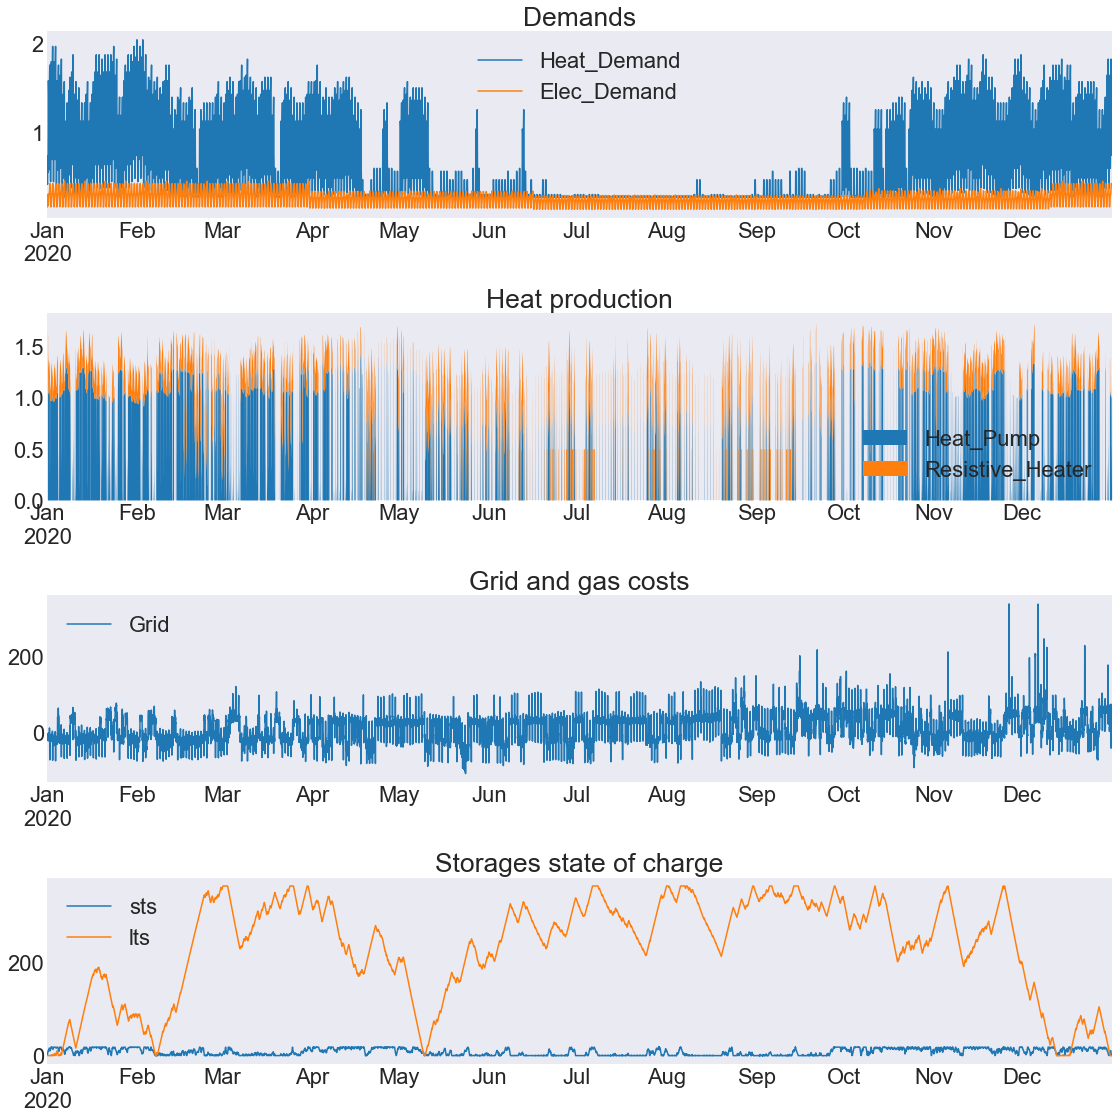

In [32]:
Network.network.generators_t.p['Heat_Pump'] = Network.network.links_t.p1.Heat_Pump * -1
Network.network.generators_t.p['Resistive_Heater'] = Network.network.links_t.p1.Resistive_Heater * -1
# ScotBord.network.generators_t.marginal_cost['Gas_Boiler'] = ScotBord.network.generators.marginal_cost.Gas_Boiler

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

Network.network.loads_t.p.rename_axis('').plot(ax=axs[0], title='Demands')
Network.network.generators_t.p.rename_axis('').drop(columns=['Grid']).plot.area(ax=axs[1], linewidth=0, title='Heat production')
Network.network.generators_t.marginal_cost.rename_axis('').plot(ax=axs[2], title='Grid and gas costs')
Network.network.stores_t.e.rename_axis('').plot(ax=axs[3], title='Storages state of charge')

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

In [33]:
Network.carbon_calculator(Network.network.generators_t.p.Grid, curtailed_wind=True)
Network.total_carbon_emissions = Network.carbon_emissions.sum().round(2)

In [34]:
Network.total_costs_obj = Network.network.objective + Network.network.objective_constant
Network.total_costs_obj

-58052.606925159576

In [35]:
Network.capex = (Network.network.links.p_nom_opt.Resistive_Heater * Network.network.links.capital_cost.Resistive_Heater +
                       Network.network.links.p_nom_opt.Heat_Pump * Network.network.links.capital_cost.Heat_Pump +
                       Network.network.stores.e_nom_opt.sts * Network.network.stores.capital_cost.sts +
                       Network.network.stores.e_nom_opt.lts * Network.network.stores.capital_cost.lts) * 20
Network.capex

490165.95411996485

In [36]:
Network.opex = Network.total_costs_obj * 20 - Network.capex
Network.opex

-1651218.0926231565

In [37]:
Network.total_costs = Network.opex + Network.capex
Network.total_costs

-1161052.1385031915

## Compare scenarios

<AxesSubplot:>

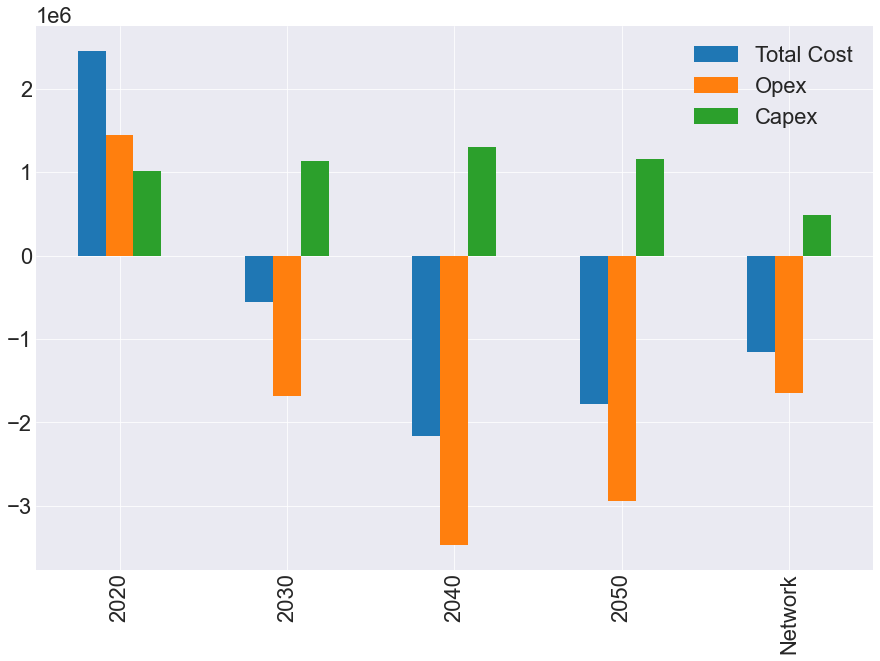

In [38]:
total_costs = [TwentyTwenty.total_costs, TwentyThirty.total_costs,
               TwentyForty.total_costs, TwentyFifty.total_costs,
               Network.total_costs]

opex = [TwentyTwenty.opex, TwentyThirty.opex,
        TwentyForty.opex, TwentyFifty.opex,
        Network.opex]

capex = [TwentyTwenty.capex, TwentyThirty.capex,
         TwentyForty.capex, TwentyFifty.capex,
         Network.capex]

df_compare = pd.DataFrame(data=[total_costs, opex, capex]).T#
df_compare.columns = ['Total Cost', 'Opex', 'Capex']
df_compare.index = ['2020', '2030', '2040', '2050', 'Network']
df_compare.plot.bar(figsize=(15,10), grid=True)

<AxesSubplot:>

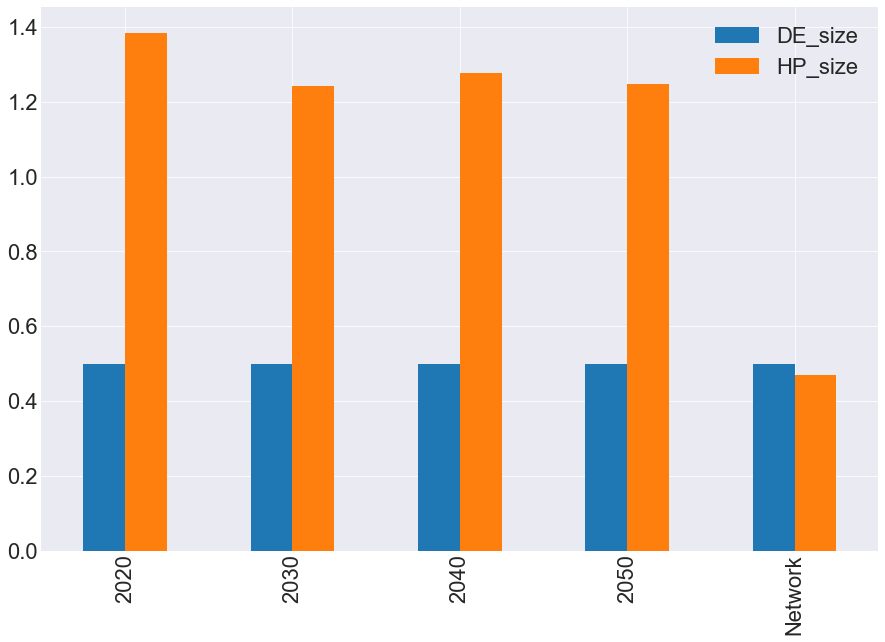

In [39]:
DE_size = [TwentyTwenty.network.links.p_nom_opt.Resistive_Heater, TwentyThirty.network.links.p_nom_opt.Resistive_Heater, 
           TwentyForty.network.links.p_nom_opt.Resistive_Heater, TwentyFifty.network.links.p_nom_opt.Resistive_Heater,
           Network.network.links.p_nom_opt.Resistive_Heater]

HP_size = [TwentyTwenty.network.links.p_nom_opt.Heat_Pump, TwentyThirty.network.links.p_nom_opt.Heat_Pump, 
           TwentyForty.network.links.p_nom_opt.Heat_Pump, TwentyFifty.network.links.p_nom_opt.Heat_Pump,
           Network.network.links.p_nom_opt.Heat_Pump]

df_compare_sizes = pd.DataFrame(data=[DE_size, HP_size]).T#
df_compare_sizes.columns = ['DE_size', 'HP_size']
df_compare_sizes.index = ['2020', '2030', '2040', '2050', 'Network']
df_compare_sizes.plot.bar(figsize=(15,10), grid=True)

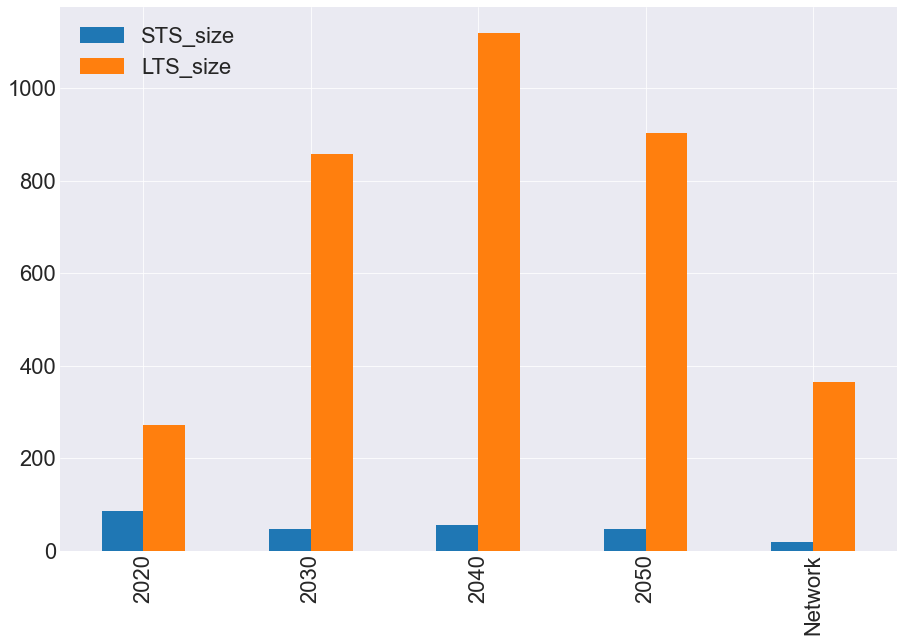

In [40]:
STS_size = [TwentyTwenty.network.stores.e_nom_opt.sts, TwentyThirty.network.stores.e_nom_opt.sts,
            TwentyForty.network.stores.e_nom_opt.sts, TwentyFifty.network.stores.e_nom_opt.sts,
            Network.network.stores.e_nom_opt.sts]

LTS_size = [TwentyTwenty.network.stores.e_nom_opt.lts, TwentyThirty.network.stores.e_nom_opt.lts,
            TwentyForty.network.stores.e_nom_opt.lts, TwentyFifty.network.stores.e_nom_opt.lts,
            Network.network.stores.e_nom_opt.lts]

df_compare_s_sizes = pd.DataFrame(data=[STS_size, LTS_size]).T#
df_compare_s_sizes.columns = ['STS_size', 'LTS_size']
df_compare_s_sizes.index = ['2020', '2030', '2040', '2050', 'Network']
df_compare_s_sizes.plot.bar(figsize=(15,10), grid=True).legend(loc='upper left')

<AxesSubplot:>

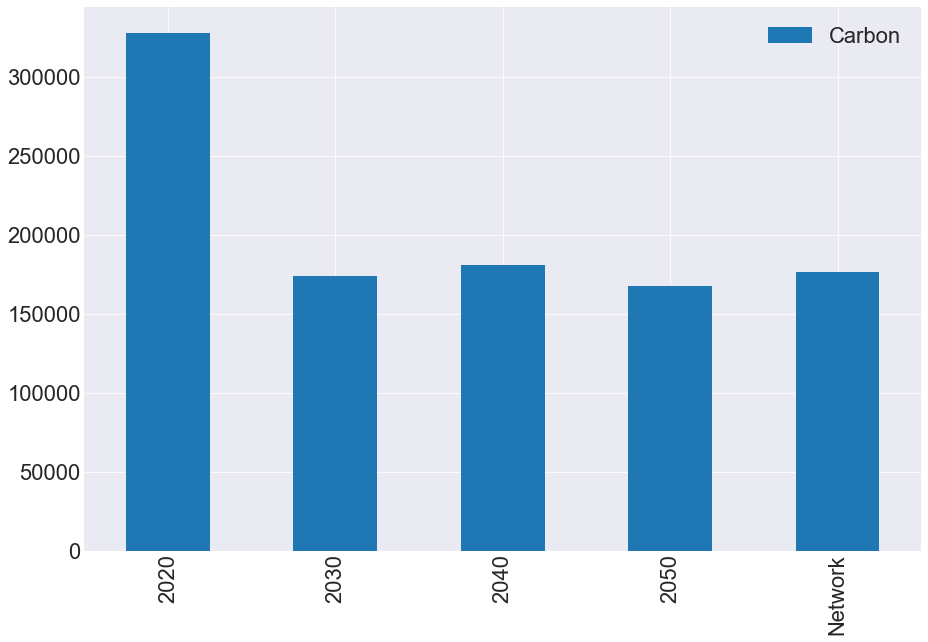

In [41]:
# check the carbon stuff
carbon_emissions = [TwentyTwenty.total_carbon_emissions, TwentyThirty.total_carbon_emissions,
                    TwentyForty.total_carbon_emissions, TwentyFifty.total_carbon_emissions,
                    Network.total_carbon_emissions]

df_compare_carbon = pd.DataFrame(data=[carbon_emissions]).T
df_compare_carbon.columns = ['Carbon']
df_compare_carbon.index = ['2020', '2030', '2040', '2050', 'Network']
df_compare_carbon.plot.bar(figsize=(15,10), grid=True)

<AxesSubplot:>

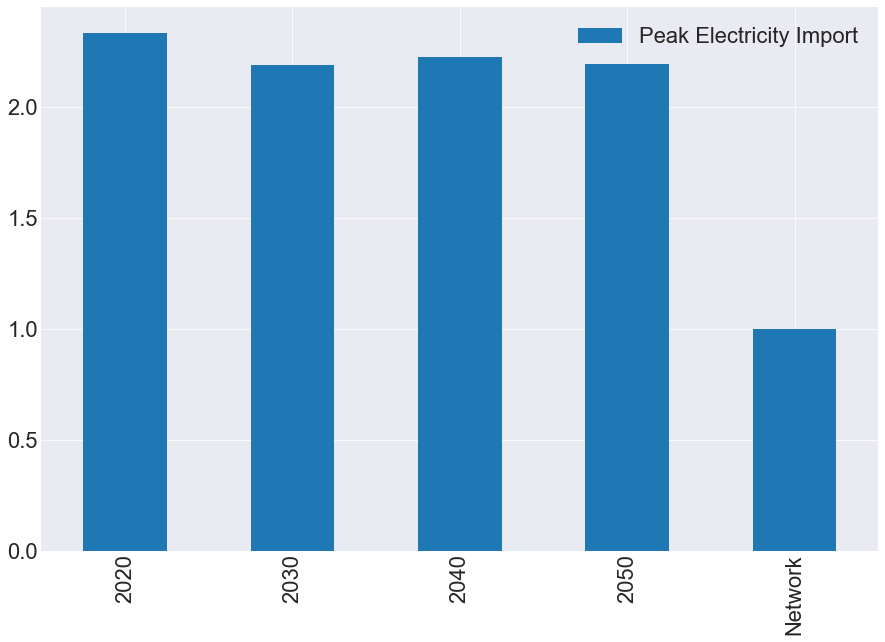

In [42]:
# peak electrical load
elec_peak_import = [TwentyTwenty.network.generators_t.p.Grid.max(), TwentyThirty.network.generators_t.p.Grid.max(),
                    TwentyForty.network.generators_t.p.Grid.max(), TwentyFifty.network.generators_t.p.Grid.max(),
                    Network.network.generators_t.p.Grid.max()]

df_compare_e_peak = pd.DataFrame(data=[elec_peak_import]).T
df_compare_e_peak.columns = ['Peak Electricity Import']
df_compare_e_peak.index = ['2020', '2030', '2040', '2050', 'Network']
df_compare_e_peak.plot.bar(figsize=(15,10), grid=True)